(181, 90, 44)
(181, 180, 88, 1)
[509.70157107]
[-32767.]
[-32767.]
[-32767.]
Combined HR Aux Data Shape: (181, 180, 88, 45)
0.0
65.5
Sliced HR Aux Data Shape: (181, 180, 88, 45)
-5.350948318234112
(180, 88, 7)
最大误差: 8.881784197001252e-16
最大误差: 8.881784197001252e-16
Defined model layers: ['initial_conv.0.weight', 'initial_conv.1.weight', 'initial_conv.1.bias', 'dense_blocks.0.layers.0.0.weight', 'dense_blocks.0.layers.0.0.bias', 'dense_blocks.0.layers.0.2.weight', 'dense_blocks.0.layers.1.0.weight', 'dense_blocks.0.layers.1.0.bias', 'dense_blocks.0.layers.1.2.weight', 'dense_blocks.0.layers.2.0.weight', 'dense_blocks.0.layers.2.0.bias', 'dense_blocks.0.layers.2.2.weight', 'dense_blocks.0.layers.3.0.weight', 'dense_blocks.0.layers.3.0.bias', 'dense_blocks.0.layers.3.2.weight', 'dense_blocks.1.layers.0.0.weight', 'dense_blocks.1.layers.0.0.bias', 'dense_blocks.1.layers.0.2.weight', 'dense_blocks.1.layers.1.0.weight', 'dense_blocks.1.layers.1.0.bias', 'dense_blocks.1.layers.1.2.weight', 'd

/tmp/ipykernel_1767089/4072911260.py:260: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start=start_date, periods=time_steps, freq='M')


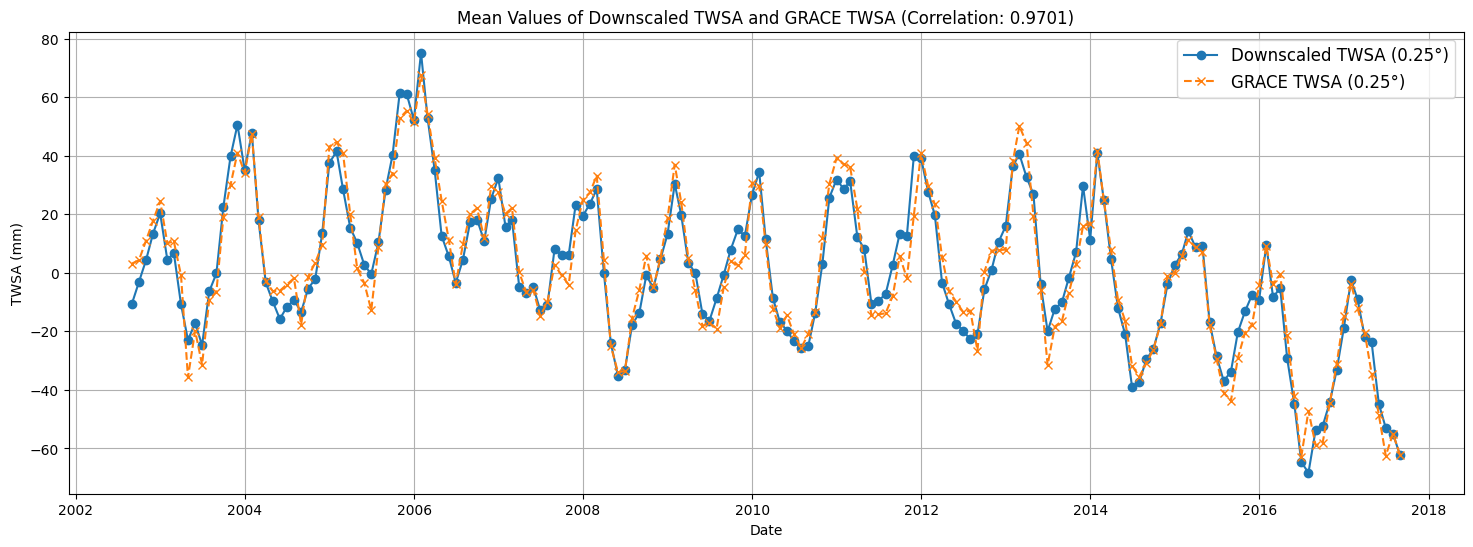

In [ ]:
import torch
import numpy as np
from model import FlexibleUpsamplingModule
from datasets import CustomDataset, load_data
from torch.utils.data import DataLoader
from utils import plot_results
import torch.nn.functional as F
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import h5py
from scipy.ndimage import zoom
from torchviz import make_dot
import hiddenlayer as hl
import pandas as pd
from netCDF4 import Dataset, date2num
from datetime import datetime, timedelta
import cv2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def smooth_spatial_bilateral(raw_downscaled, d=1, sigma_color=75, sigma_space=75):
    n, w, l = raw_downscaled.shape
    n=1
    smoothed = np.zeros_like(raw_downscaled)
    
    for i in range(n):
        raw_slice = raw_downscaled[i, :, :]
        nan_mask = np.isnan(raw_slice)
        
        # Temporarily fill NaN values with a constant value (e.g., the mean of valid values)
        mean_value = np.nanmean(raw_slice)
        filled_slice = np.where(nan_mask, mean_value, raw_slice)
        
        # Apply bilateral filtering on the filled slice
        filled_slice = filled_slice.astype(np.float32)  # OpenCV requires float32
        smoothed_slice = cv2.bilateralFilter(filled_slice, d=d, sigmaColor=sigma_color, sigmaSpace=sigma_space)
        
        # Restore NaN values in their original locations
        smoothed_slice[nan_mask] = np.nan
        smoothed[i, :, :] = smoothed_slice
    
    return smoothed
def visualize_model(model, filename,x):
    #x = torch.randn(input_size)
    y = model(x)
    # Generate a simplified graph
    dot = make_dot(y, params=dict(model.named_parameters()), show_attrs=False, show_saved=False)
    # Simplify node labels by removing variable names and types
    for node in dot.body:
        if 'label=' in node:
            # Remove parameter details from the label
            node = node.split('label="')[0] + 'label="..."' + ', shape=box]'
    dot.body = [node for node in dot.body]
    dot.format = 'png'
    dot.render(filename, cleanup=True)
    print(f"Model architecture saved as '{filename}.png'")
def simple_histogram_matching(source, reference):
    oldshape = source.shape
    source = source.ravel()
    reference = reference.ravel()

    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True, return_counts=True)
    t_values, t_counts = np.unique(reference, return_counts=True)

    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    return interp_t_values[bin_idx].reshape(oldshape)

def apply_histogram_matching(hr_generated, lr_grace_025):
    hr_generated_np = hr_generated.detach().cpu().numpy()
    lr_grace_025_np = lr_grace_025.detach().cpu().numpy()

    matched = np.array([simple_histogram_matching(hg, lg) for hg, lg in zip(hr_generated_np, lr_grace_025_np)])
    return torch.tensor(matched).to(device)

def mild_histogram_matching(source, reference, weight=0.2):
    oldshape = source.shape
    source = source.ravel()
    reference = reference.ravel()

    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True, return_counts=True)
    t_values, t_counts = np.unique(reference, return_counts=True)

    s_quantiles = np.cumsum(s_counts).astype(np.float64) / np.sum(s_counts)
    t_quantiles = np.cumsum(t_counts).astype(np.float64) / np.sum(t_counts)

    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    matched = interp_t_values[bin_idx].reshape(oldshape)
    adjusted = (1 - weight) * source + weight * matched.ravel()
    return adjusted.reshape(oldshape)

def apply_mild_histogram_matching(hr_generated, lr_grace_025, weight=0.2):
    hr_generated_np = hr_generated.detach().cpu().numpy()
    lr_grace_025_np = lr_grace_025.detach().cpu().numpy()

    matched = np.array([mild_histogram_matching(hg, lg, weight) for hg, lg in zip(hr_generated_np, lr_grace_025_np)])
    return torch.tensor(matched).to(device)

def smooth_blend(hr_generated, hr_grace, region, sigma=5):
    start_row, end_row, start_col, end_col = region
    
    region_generated = hr_generated[:, :, start_row:end_row, start_col:end_col]
    region_grace = hr_grace[:, :, start_row:end_row, start_col:end_col]
    
    mask = np.ones((end_row - start_row, end_col - start_col), dtype=float)
    mask[0:sigma, :] = np.linspace(0, 1, sigma)[:, None]
    mask[-sigma:, :] = np.linspace(1, 0, sigma)[:, None]
    mask[:, 0:sigma] = np.maximum(mask[:, 0:sigma], np.linspace(0, 1, sigma)[None, :])
    mask[:, -sigma:] = np.maximum(mask[:, -sigma:], np.linspace(1, 0, sigma)[None, :])
    mask = gaussian_filter(mask, sigma=sigma)
    
    mask = torch.tensor(mask, dtype=torch.float32, device=hr_generated.device).unsqueeze(0).unsqueeze(0)
    
    blended_region = region_generated * (1 - mask) + region_grace * mask
    
    hr_generated[:, :, start_row:end_row, start_col:end_col] = blended_region
    
    return hr_generated

def predict_and_plot(upsampling_module_path = 'model12_upsampling_module.pth'):
    discriminator_path = 'model2_discriminator.pth'
    [elr_grace_05,trend05], [elr_grace_025,trend25], hr_aux, grace_scaler_05, grace_scaler_025, aux_scalers = load_data()
    dataset = CustomDataset(elr_grace_05, elr_grace_025, hr_aux, augment=False)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    upsampling_module = FlexibleUpsamplingModule(input_channels=hr_aux.shape[-1] + 1, attention_type='senet').to(device)
    print("Defined model layers:", [name for name, _ in upsampling_module.named_parameters()])
    print("State_dict layers:", list(torch.load(upsampling_module_path).keys()))

    upsampling_module.load_state_dict(torch.load(upsampling_module_path))

    region = (0, 90, 0, 44)
    loader = DataLoader(dataset, batch_size=8)
    
    degraded_hr_mean_values_list = []
    lr_grace_025_mean_values_list = []
    hr_grace_mean_values_list = []
    res=[]
    tpbl=np.load('tpb_l.npy')
    zoom_factors = (2, 2)
    tpbh=np.load('tpb_h.npy')
    # Perform bicubic interpolation using the `zoom` function from scipy.ndimage
    tpbl = zoom(tpbl, zoom_factors, order=1)  # order=3 for bicubic interpolation
    i=0
    for batch in loader:
        lr_grace_05, lr_grace_025, hr_aux = batch
        i=i+1
        lr_grace_05, lr_grace_025, hr_aux = lr_grace_05.to(device), lr_grace_025.to(device), hr_aux.to(device)
        hr_grace = torch.nn.functional.interpolate(lr_grace_025, scale_factor=4, mode='bicubic', align_corners=False)
        lr_grace = F.interpolate(lr_grace_05, scale_factor=0.5, mode='bicubic', align_corners=False)
        downsampled_aux = F.interpolate(hr_aux, scale_factor=0.25, mode='bicubic', align_corners=False)
        combined_input = torch.cat([lr_grace, downsampled_aux], dim=1)
        
        hr_generated = upsampling_module(combined_input)
        if i==1:
            visualize_model(upsampling_module, 'Generator',combined_input)
        hr_generated_matched = apply_mild_histogram_matching(hr_generated, lr_grace_025)
        degraded_hr_generated = hr_generated_matched#smooth_blend(hr_generated_matched, hr_grace, region=region)

        t = degraded_hr_generated.size()
        print(t)
        #tpbh=np.load('tpb_h.npy')
        #degraded_hr_generated[:,:,tpbh==0]=np.nan  
        #lr_grace_05f[:,:,tpbl==0]=np.nan
        degraded_hr_mean_values = degraded_hr_generated.nanmean(dim=[1, 2, 3], keepdim=True).detach().cpu().numpy().flatten()
        degraded_hr_mean_values_list.append(degraded_hr_mean_values)
        #lr_grace_025[:,:,tpbh==0]=np.nan
        lr_grace_025_mean_values = lr_grace_025.nanmean(dim=[1, 2, 3], keepdim=True).detach().cpu().numpy().flatten()
        lr_grace_025_mean_values_list.append(lr_grace_025_mean_values)
        
        hr_grace_mean_values = hr_grace.mean(dim=[1, 2, 3], keepdim=True).detach().cpu().numpy().flatten()
        hr_grace_mean_values_list.append(hr_grace_mean_values)
        res.append(degraded_hr_generated.cpu().numpy())

        #plot_results(lr_grace_05f[0,0].cpu(), degraded_hr_generated[0,0].cpu(), lr_grace_025[0,0].cpu(), True)
    res=np.concatenate(res, axis=0)
    res=np.squeeze(res)
    res=res+trend25
    elr_grace_025=elr_grace_025+trend25
    res = grace_scaler_025.inverse_transform(res.reshape(-1, 1)).reshape(res.shape)
    elr_grace_025 = grace_scaler_025.inverse_transform(elr_grace_025.reshape(-1, 1)).reshape(elr_grace_025.shape)
    
    
    #res = grace_scaler_025.inverse_transform(res.reshape(-1, 1)).reshape(res.shape)
    elr_grace_025[:, tpbh==0]=np.nan
    res[:, tpbh==0]=np.nan 
    save_path = 'grace025.h5'
    
    # Save the dataset
    with h5py.File(save_path, 'w') as f:
        f.create_dataset('data', data=elr_grace_025)
    origin= np.nanmean(elr_grace_025, axis=(1, 2))
    pred = np.nanmean(res, axis=(1, 2))
    print(np.shape(res))
    print(np.shape(elr_grace_025))
    bias=elr_grace_025-res
    # Create a mask of NaN values
    nan_mask = np.isnan(bias)

    # Replace NaN values with a filler value (e.g., mean or zero)
    bias_filled = np.where(nan_mask, np.nanmean(bias), bias)

    # Perform interpolation on the filled data
    scale_factors = (1, 4, 4)
    biash = zoom(bias_filled, scale_factors, order=0, mode='nearest')

    # Restore the NaN values in the interpolated data by applying the mask
    nan_mask_interpolated = zoom(nan_mask.astype(float), scale_factors, order=0, mode='nearest')
    biash[nan_mask_interpolated > 0] = np.nan

    block = np.ones((1, 4, 4))

    # Use np.kron to perform the Kronecker product
    biash = np.repeat(np.repeat(bias, 4, axis=1), 4, axis=2)
    save_path = 'grace05.h5'
    elr_grace_05=elr_grace_05+trend05
    # Save the dataset
    with h5py.File(save_path, 'w') as f:
        f.create_dataset('data', data=elr_grace_05)
    #res=grace_scaler_025.inverse_transform(res.reshape(-1, 1)).reshape(res.shape)
    save_path = 'biash.h5'
    
    # Save the dataset
    with h5py.File(save_path, 'w') as f:
        f.create_dataset('data', data=biash)
    #res=grace_scaler_025.inverse_transform(res.reshape(-1, 1)).reshape(res.shape)
    save_path = 'valid.h5'
    
    # Save the dataset
    with h5py.File(save_path, 'w') as f:
        f.create_dataset('data', data=res)
    degraded_hr_mean_values_all = np.concatenate(degraded_hr_mean_values_list, axis=0)
    lr_grace_025_mean_values_all = np.concatenate(lr_grace_025_mean_values_list, axis=0)
    hr_grace_mean_values_all = np.concatenate(hr_grace_mean_values_list, axis=0)
    print(np.shape(res))
    #print(degraded_hr_mean_values_all)

    # Calculate correlation
    print(np.shape(pred))
    print(np.shape(origin))
    correlation, _ = pearsonr(pred, origin)
    print(f"Pearson correlation: {correlation:.4f}")

    # Plot the results
    import matplotlib.pyplot as plt
    #import pandas as pd

    # Example data (replace with your actual 'pred' and 'origin' data)
    # pred = [...] 
    # origin = [...]

    # Generate date range starting from August 2008 with monthly frequency
    start_date = '2002-08'
    time_steps = len(pred)  # Assuming pred and origin have the same length
    dates = pd.date_range(start=start_date, periods=time_steps, freq='M')

    # Calculate the correlation between 'pred' and 'origin'
    correlation = pd.Series(pred).corr(pd.Series(origin))

    # Plotting
    # Plotting
    plt.figure(figsize=(18, 6))
    plt.plot(dates, pred*10, marker='o', linestyle='-', label='Downscaled TWSA (0.25°)')
    plt.plot(dates, origin*10, marker='x', linestyle='--', label='GRACE TWSA (0.25°)')
    plt.xlabel('Date')
    plt.ylabel('TWSA (mm)')
    plt.title(f'Mean Values of Downscaled TWSA and GRACE TWSA (Correlation: {correlation:.4f})')
    plt.legend(fontsize=12)
    plt.grid(True)

    # Save as uncompressed PNG
    plt.savefig('downscaled_vs_grace_tws_plot.png', format='png', dpi=600)  # Adjust DPI for higher quality if needed
    
    return pred

pred025=predict_and_plot()

(181, 90, 44)
(181, 180, 88, 1)
[509.70157107]
[-32767.]
[-32767.]
[-32767.]
Combined HR Aux Data Shape: (181, 180, 88, 45)
0.0
65.5
Sliced HR Aux Data Shape: (181, 180, 88, 45)
-5.350948318234112
(180, 88, 7)
最大误差: 8.881784197001252e-16
最大误差: 8.881784197001252e-16
(181, 900, 440)
(181, 180, 88)
(181, 1, 180, 88)


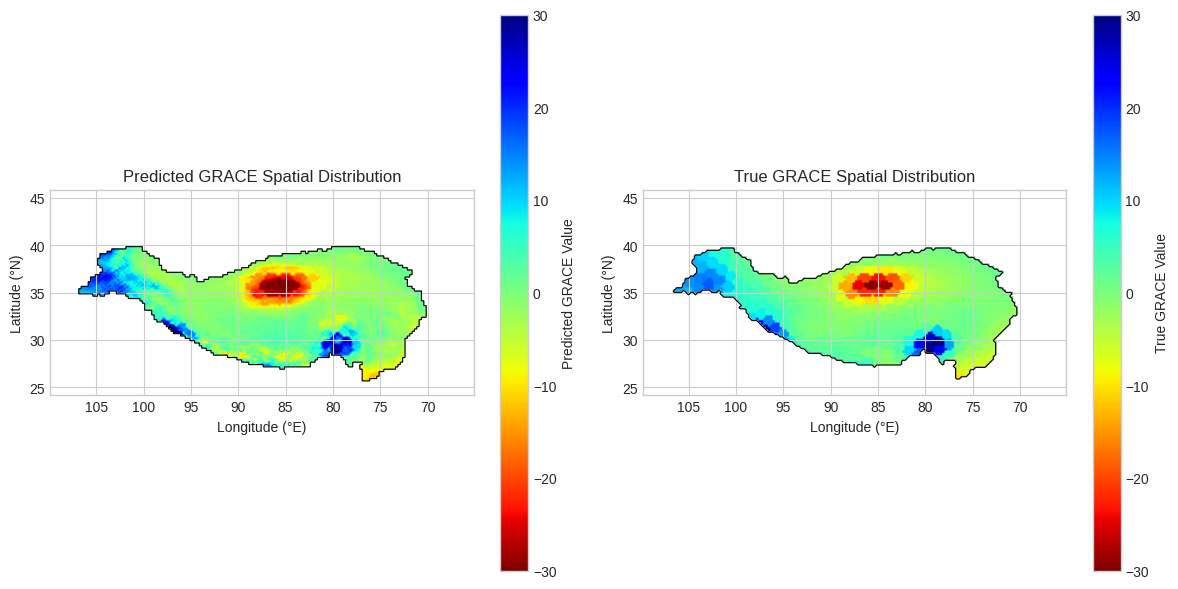

(181, 900, 440)
The biash dataset contains only NaN values!
The res dataset contains only NaN values!
The downscaled dataset contains valid values.
(181,)
(181,)
Pearson correlation: 0.8606
(181, 180, 88)


/tmp/ipykernel_1767089/644203250.py:392: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start=start_date, periods=time_steps, freq='M')


(181, 180, 88)


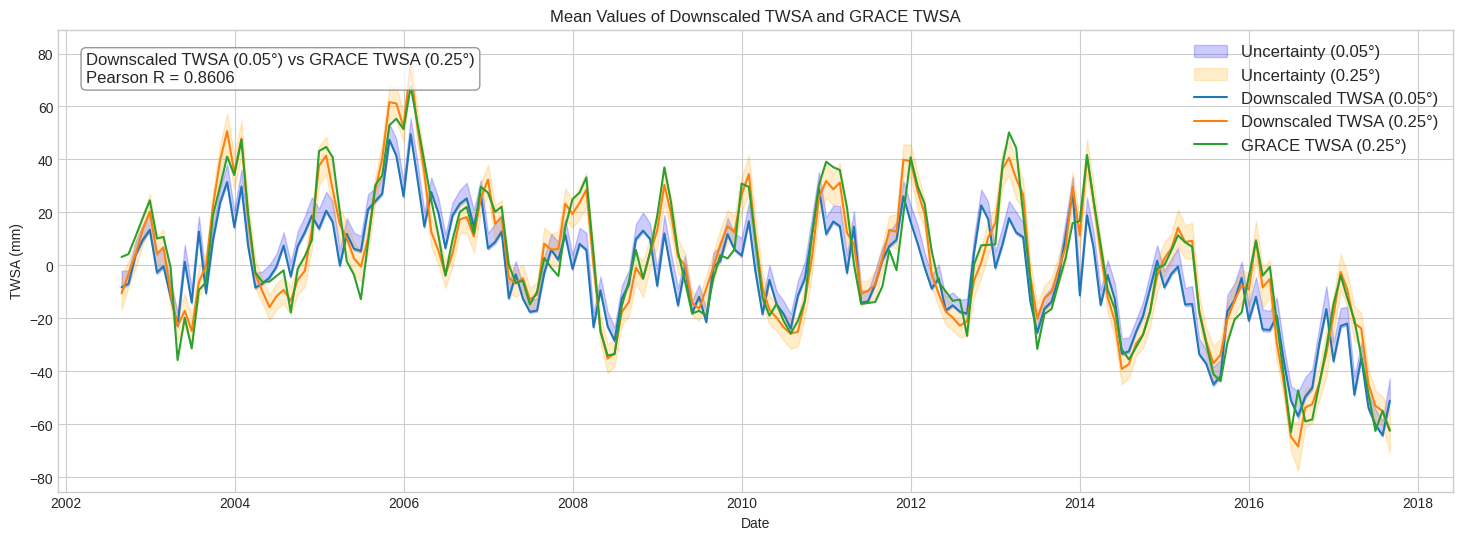

/tmp/ipykernel_1767089/644203250.py:439: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start=start_date, periods=time_steps, freq='M')


<Figure size 640x480 with 0 Axes>

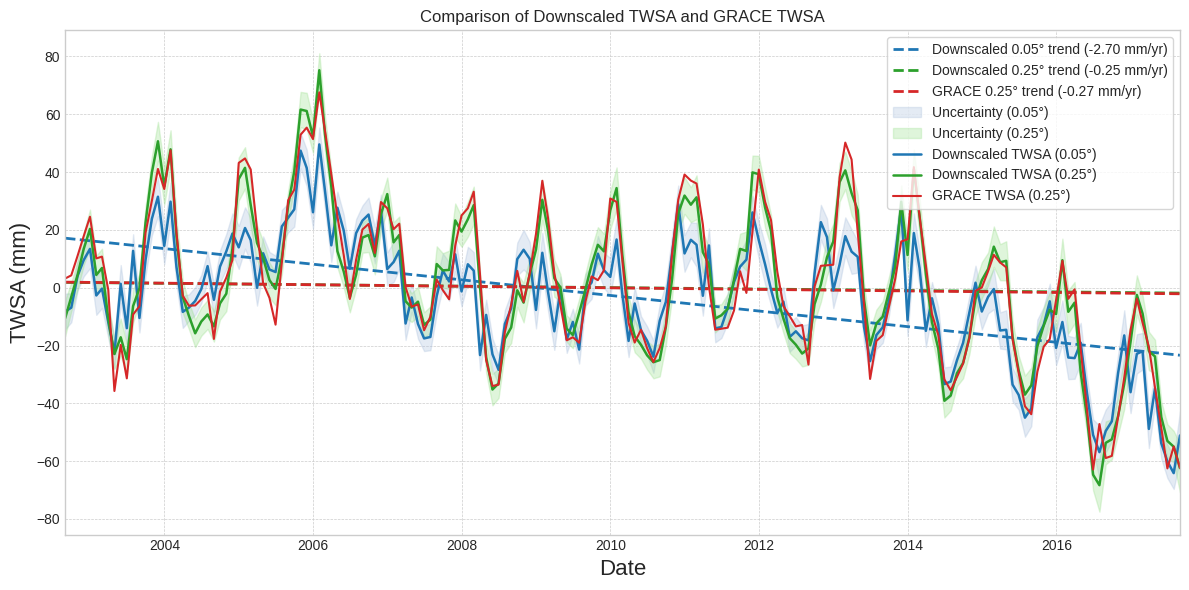

array([-8.23400026e+00, -6.90180977e+00,  4.07388021e+00,  9.54413401e+00,
        1.34393921e+01, -2.67646095e+00, -3.23581401e-01, -1.19225683e+01,
       -2.28070282e+01,  1.36095431e+00, -1.39962555e+01,  1.27481394e+01,
       -1.04709082e+01,  9.59065562e+00,  2.37945140e+01,  3.14763830e+01,
        1.44778224e+01,  2.97669122e+01,  7.18980927e+00, -8.35510502e+00,
       -6.88553230e+00, -4.60008103e+00, -4.77604908e-01,  7.46538059e+00,
       -4.18056627e+00,  7.30308655e+00,  1.25729679e+01,  1.87414143e+01,
        1.39599402e+01,  2.06567546e+01,  1.64517052e+01, -2.75389093e-02,
        1.19250721e+01,  6.28185472e+00,  5.44240092e+00,  2.12129449e+01,
        2.42234072e+01,  2.71125426e+01,  4.74086150e+01,  4.14565859e+01,
        2.61060149e+01,  4.95759273e+01,  3.34836972e+01,  1.46623113e+01,
        2.76654613e+01,  1.97878001e+01,  6.57308244e+00,  1.88745026e+01,
        2.32152345e+01,  2.53111268e+01,  1.46519377e+01,  2.68172304e+01,
        6.46484169e+00,  

In [6]:
import torch
import numpy as np
from model import FlexibleUpsamplingModule
from datasets import CustomDataset, load_data
from torch.utils.data import DataLoader
from utils import plot_results
import torch.nn.functional as F
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import h5py
from scipy.ndimage import zoom
from torch.cuda.amp import autocast
import pandas as pd
import matplotlib.dates as mdates

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def simple_histogram_matching(source, reference):
    oldshape = source.shape
    source = source.ravel()
    reference = reference.ravel()

    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True, return_counts=True)
    t_values, t_counts = np.unique(reference, return_counts=True)

    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    return interp_t_values[bin_idx].reshape(oldshape)

def apply_histogram_matching(hr_generated, lr_grace_025):
    hr_generated_np = hr_generated.detach().cpu().numpy()
    lr_grace_025_np = lr_grace_025.detach().cpu().numpy()

    matched = np.array([simple_histogram_matching(hg, lg) for hg, lg in zip(hr_generated_np, lr_grace_025_np)])
    return torch.tensor(matched).to(device)

def mild_histogram_matching(source, reference, weight=0.2):
    oldshape = source.shape
    source = source.ravel()
    reference = reference.ravel()

    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True, return_counts=True)
    t_values, t_counts = np.unique(reference, return_counts=True)

    s_quantiles = np.cumsum(s_counts).astype(np.float64) / np.sum(s_counts)
    t_quantiles = np.cumsum(t_counts).astype(np.float64) / np.sum(t_counts)

    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    matched = interp_t_values[bin_idx].reshape(oldshape)
    adjusted = (1 - weight) * source + weight * matched.ravel()
    return adjusted.reshape(oldshape)

def apply_mild_histogram_matching(hr_generated, lr_grace_025, weight=0.0):
    hr_generated_np = hr_generated.detach().cpu().numpy()
    lr_grace_025_np = lr_grace_025.detach().cpu().numpy()

    matched = np.array([mild_histogram_matching(hg, lg, weight) for hg, lg in zip(hr_generated_np, lr_grace_025_np)])
    return torch.tensor(matched).to(device)

def smooth_blend(hr_generated, hr_grace, region, sigma=5):
    start_row, end_row, start_col, end_col = region
    
    region_generated = hr_generated[:, :, start_row:end_row, start_col:end_col]
    region_grace = hr_grace[:, :, start_row:end_row, start_col:end_col]
    
    mask = np.ones((end_row - start_row, end_col - start_col), dtype=float)
    mask[0:sigma, :] = np.linspace(0, 1, sigma)[:, None]
    mask[-sigma:, :] = np.linspace(1, 0, sigma)[:, None]
    mask[:, 0:sigma] = np.maximum(mask[:, 0:sigma], np.linspace(0, 1, sigma)[None, :])
    mask[:, -sigma:] = np.maximum(mask[:, -sigma:], np.linspace(1, 0, sigma)[None, :])
    mask = gaussian_filter(mask, sigma=sigma)
    
    mask = torch.tensor(mask, dtype=torch.float32, device=hr_generated.device).unsqueeze(0).unsqueeze(0)
    
    blended_region = region_generated * (1 - mask) + region_grace * mask
    
    hr_generated[:, :, start_row:end_row, start_col:end_col] = blended_region
    
    return hr_generated
def _plot_spatial_distribution(predicted, target):
        sample_idx = 0  # Change to visualize other samples
        vmin, vmax = -30, 30  # Fixed color scale range

        pred_sample = predicted[sample_idx].T  # Transpose for rotation
        true_sample = target[sample_idx].T

        # Define coordinate bounds
        lat_min, lat_max = 24.125, 45.875
        lon_min, lon_max = 65.125, 109.875
        extent = [lon_max, lon_min, lat_min, lat_max]  # Reverse x-axis (lon), normal y-axis (lat)

        plt.figure(figsize=(12, 6))

        # Plot predicted
        ax1 = plt.subplot(1, 2, 1)
        im1 = ax1.imshow(
            pred_sample,
            cmap='jet_r',
            vmin=vmin,
            vmax=vmax,
            extent=extent,
            origin='lower'
        )
        plt.colorbar(im1, ax=ax1, label='Predicted GRACE Value')
        ax1.contour(
            np.isfinite(pred_sample),
            levels=[0.5],
            colors='black',
            linewidths=0.8,
            extent=extent,
            origin='lower'
        )
        ax1.set_title('Predicted GRACE Spatial Distribution')
        ax1.set_xlabel('Longitude (°E)')
        ax1.set_ylabel('Latitude (°N)')

        # Plot true
        ax2 = plt.subplot(1, 2, 2)
        im2 = ax2.imshow(
            true_sample,
            cmap='jet_r',
            vmin=vmin,
            vmax=vmax,
            extent=extent,
            origin='lower'
        )
        plt.colorbar(im2, ax=ax2, label='True GRACE Value')
        ax2.contour(
            np.isfinite(true_sample),
            levels=[0.5],
            colors='black',
            linewidths=0.8,
            extent=extent,
            origin='lower'
        )
        ax2.set_title('True GRACE Spatial Distribution')
        ax2.set_xlabel('Longitude (°E)')
        ax2.set_ylabel('Latitude (°N)')

        plt.tight_layout()
        plt.savefig("spatial_distribution_comparisondan.pdf", format='pdf', bbox_inches="tight")
        plt.show()
def predict_and_plot(upsampling_module_path = 'model12_upsampling_module.pth', pred1=None):#modelself2_upsampling_module.pth
    discriminator_path = 'model2_discriminator.pth'
    [lr_grace_05,trend05], [elr_grace_025,trend25], hr_aux, grace_scaler_05, grace_scaler_025, aux_scalers = load_data()
    dataset = CustomDataset(lr_grace_05, elr_grace_025, hr_aux, augment=False)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    upsampling_module = FlexibleUpsamplingModule(input_channels=hr_aux.shape[-1] + 1, attention_type='senet').to(device)

    upsampling_module.load_state_dict(torch.load(upsampling_module_path))

    region = (0, 90, 0, 44)
    loader = DataLoader(dataset, batch_size=4)
    
    degraded_hr_mean_values_list = []
    lr_grace_025_mean_values_list = []
    hr_grace_mean_values_list = []
    res=[]
    tpbl=np.load('tpb_l.npy')
    zoom_factors = (2, 2)
    tpbh=np.load('tpb_h.npy')
    zoomf=(5,5)
    tpbhh=zoom(tpbh, zoomf, order=1) 
    # Perform bicubic interpolation using the `zoom` function from scipy.ndimage
    tpbl = zoom(tpbl, zoom_factors, order=1)  # order=3 for bicubic interpolation
    with torch.no_grad():
        for batch in loader:
            lr_grace_05, lr_grace_025, hr_aux = batch
            del lr_grace_05
            lr_grace_025, hr_aux = lr_grace_025.to(device), hr_aux.to(device)
            hr_grace = torch.nn.functional.interpolate(lr_grace_025, scale_factor=4, mode='bicubic', align_corners=False)

            combined_input = torch.cat([lr_grace_025, hr_aux], dim=1)
            #combined_input = torch.nn.functional.interpolate(combined_input, scale_factor=1.25, mode='bicubic', align_corners=False)
            
            hr_generated = upsampling_module(combined_input)
            hr_generated = torch.nn.functional.interpolate(hr_generated, scale_factor=1.25, mode='bicubic', align_corners=False)
            hr_generated_matched = apply_mild_histogram_matching(hr_generated, lr_grace_025)
            
            degraded_hr_generated = smooth_blend(hr_generated_matched, hr_grace, region=region)
            #degraded_hr_generated[:,:,tpbhh == 0] = torch.nan
            res.append(degraded_hr_generated.cpu().numpy())
            
            # Clean up and free memory after each batch
            del lr_grace_025, hr_aux, hr_grace, combined_input, hr_generated, hr_generated_matched, degraded_hr_generated
            torch.cuda.empty_cache()
    res=np.concatenate(res, axis=0)
    res=np.squeeze(res)
    zoomf=(1,5,5)
    zoomfs=(1,1.25,1.25)
    trend00=zoom(trend25, zoomf, order=3) 
    # trend00 = np.repeat(np.repeat(trend25, 4, axis=1), 4, axis=2)
    elr_grace_025=elr_grace_025+trend25
    res=res+trend00
    
    
    res = grace_scaler_025.inverse_transform(res.reshape(-1, 1)).reshape(res.shape)
    elr_grace_025 = grace_scaler_025.inverse_transform(elr_grace_025.reshape(-1, 1)).reshape(elr_grace_025.shape)
    
    res=res*10
    elr_grace_025[:, tpbh==0]=np.nan
    
    origin= np.nanmean(elr_grace_025, axis=(1, 2))
    
    res[:, tpbhh == 0] = torch.nan
    pred = np.nanmean(res, axis=(1, 2))
    print(np.shape(res))
    
    print(np.shape(elr_grace_025))
    '''
    bias=elr_grace_025-res
    scale_factors = (1, 4, 4)
    print(np.shape(bias))
    biash=zoom(bias, scale_factors, order=3, mode='nearest')
    save_path = 'biash.h5'
    
    # Save the dataset
    with h5py.File(save_path, 'w') as f:
        f.create_dataset('data', data=biash)
    '''
    read_path = 'biash.h5'

    # Open and read the HDF5 file
    with h5py.File(read_path, 'r') as f:
        biash = f['data'][:]  # Reading the entire dataset into a NumPy array
    #res=grace_scaler_025.inverse_transform(res.reshape(-1, 1)).reshape(res.shape)
    # File path for saving
    save_path = 'raw_downscaled.h5'
    
    # Save the dataset
    with h5py.File(save_path, 'w') as f:
        f.create_dataset('data', data=res)
    save_path = 'downscaled_grace_tws_data_with_uncertainty_gan_danet.nc'
    start_date = '2002-08'  # Year-Month
    start_lat = 24.025
    start_lon = 65.025
    resolution = 0.05  # Degree
    resolution1 = 0.25 
    time_dim, lon_dim, lat_dim = res.shape  # Assuming res has shape (time, lat, lon)
    time_dim1, lon_dim1, lat_dim1 = elr_grace_025.shape 
    start_lat1 = 24.125
    start_lon1 = 65.125
    # Generate time values (assuming monthly data starting from '2002-08')
    time_values = [datetime(2002, 8, 1) + timedelta(days=30*i) for i in range(time_dim)]

    # Generate latitudes and longitudes
    lat_values = np.arange(start_lat, start_lat + lat_dim * resolution, resolution)
    lon_values = np.arange(start_lon, start_lon + lon_dim * resolution, resolution)
    lat_values1 = np.arange(start_lat1, start_lat1 + lat_dim1 * resolution1, resolution1)
    lon_values1 = np.arange(start_lon1, start_lon1 + lon_dim1 * resolution1, resolution1)
    # Load uncertainty data
    uncr = np.load('ensemble_uncertainty.npy')
    print(np.shape(uncr))
    uncr=np.squeeze(uncr)
    # Handle uncertainty for specific conditions
    scale_factors = (1, 5, 5)
    unc = zoom(uncr, scale_factors, order=0, mode='nearest')
    unc[:, tpbhh == 0] = np.nan
    uncr[:, tpbh == 0] = np.nan
    #unc = np.nanmean(unc, axis=0)  # Assuming you want to average across ensemble members
    #res = smooth_spatial_bilateral(res, d=8, sigma_color=75, sigma_space=75)
    resss=res/10
    _plot_spatial_distribution(resss, elr_grace_025)
    # Create the HDF5 file
    with Dataset(save_path, 'w', format='NETCDF4') as nc:
        # Create dimensions
        nc.createDimension('time', time_dim)
        nc.createDimension('lat', lat_dim)
        nc.createDimension('lon', lon_dim)

        # Create variables
        times = nc.createVariable('time', 'f4', ('time',))
        lats = nc.createVariable('lat', 'f4', ('lat',))
        lons = nc.createVariable('lon', 'f4', ('lon',))

        # Create data and uncertainty variables
        data_var = nc.createVariable('data', 'f4', ('time', 'lat', 'lon'), zlib=True)
        unc_var = nc.createVariable('uncertainty', 'f4', ('time', 'lat', 'lon'), zlib=True)

        # Assign coordinate values
        times[:] = date2num(time_values, units='days since 2002-08-01', calendar='standard')
        lats[:] = lat_values
        lons[:] = lon_values
        ress=np.transpose(res,(0,2,1))
        unc=np.transpose(unc,(0,2,1))
        # Assign data
        data_var[:] = ress
        unc_var[:] = unc

        # Assign metadata to variables
        times.units = 'days since 2002-08-01'
        times.calendar = 'standard'

        lats.units = 'degrees_north'
        lons.units = 'degrees_east'

        data_var.units = 'cm'
        data_var.source = 'GRACE/GRACE-FO CSR Mascon RL06'
        data_var.description = 'Downscaled GRACE Terrestrial Water Storage Anomaly data with uncertainty'
        data_var.spatial_resolution = '0.05°'
        data_var.original_resolution = '0.25°'

        # Assign metadata to file
        nc.model = 'GAN-DANet'
        nc.date_created = datetime.now().strftime('%Y-%m-%d')
        nc.file_description = 'This file contains downscaled TWSA data from GRACE with associated uncertainty estimates.'
        nc.uncertainty_method = 'Uncertainty is averaged across ensemble predictions.'
        nc.time_period = '2002-08 to end of dataset'
        nc.citation = 'Please cite the relevant GRACE/GRACE-FO mission data if using this dataset.'
    sasp='grace_025.nc'    
    with Dataset(sasp, 'w', format='NETCDF4') as nc:
        # Create dimensions
        nc.createDimension('time', time_dim)
        nc.createDimension('lat', lat_dim1)
        nc.createDimension('lon', lon_dim1)

        # Create variables
        times = nc.createVariable('time', 'f4', ('time',))
        lats1 = nc.createVariable('lat', 'f4', ('lat',))
        lons1 = nc.createVariable('lon', 'f4', ('lon',))

        # Create data and uncertainty variables
        data_var = nc.createVariable('data', 'f4', ('time', 'lat', 'lon'), zlib=True)
        #unc_var = nc.createVariable('uncertainty', 'f4', ('time', 'lat', 'lon'), zlib=True)

        # Assign coordinate values
        times[:] = date2num(time_values, units='days since 2002-08-01', calendar='standard')
        lats1[:] = lat_values1
        lons1[:] = lon_values1
        ress=np.transpose(elr_grace_025,(0,2,1))
        #unc=np.transpose(unc,(0,2,1))
        # Assign data
        data_tmp=ress*10
        data_var[:] = data_tmp

        # Assign metadata to variables
        times.units = 'days since 2002-08-01'
        times.calendar = 'standard'

        lats1.units = 'degrees_north'
        lons1.units = 'degrees_east'

        data_var.units = 'cm'
        data_var.source = 'GRACE/GRACE-FO CSR Mascon RL06'
        data_var.description = 'Downscaled GRACE Terrestrial Water Storage Anomaly data with uncertainty'
        data_var.original_resolution = '0.25°'

        # Assign metadata to file
        nc.date_created = datetime.now().strftime('%Y-%m-%d')
        nc.file_description = 'This file contains downscaled TWSA data from GRACE with associated uncertainty estimates.'
        nc.time_period = '2002-08 to end of dataset'
        nc.citation = 'Please cite the relevant GRACE/GRACE-FO mission data if using this dataset.'    
    save_path = 'downscaled.h5'
    zoomfs=(1,1.25,1.25)
    biash=zoom(biash, zoomfs, order=3) 
    res=res+biash
    # Save the dataset
    with h5py.File(save_path, 'w') as f:
        f.create_dataset('data', data=res)

    print(np.shape(res))
    #print(degraded_hr_mean_values_all)
    if np.isnan(biash).all():
        print("The biash dataset contains only NaN values!")
    else:
        print("The res dataset contains valid values.")
    if np.isnan(res).all():
        print("The res dataset contains only NaN values!")
    else:
        print("The res dataset contains valid values.")

    if np.isnan(elr_grace_025).all():
        print("The downscaled dataset contains only NaN values!")
    else:
        print("The downscaled dataset contains valid values.")
    # Calculate correlation
    print(np.shape(pred))
    print(np.shape(origin))
    correlation, _ = pearsonr(pred, origin)
    print(f"Pearson correlation: {correlation:.4f}")
# Generate date range starting from August 2008 with monthly frequency
    start_date = '2002-08'
    time_steps = len(pred)  # Assuming pred and origin have the same length
    dates = pd.date_range(start=start_date, periods=time_steps, freq='M')
    unc=np.load('ensemble_uncertainty.npy')
    
    unc=np.squeeze(unc)
    print(np.shape(unc))
    unch = zoom(unc, scale_factors, order=0, mode='nearest')
    unc[:,tpbh==0]=np.nan
    unch[:,tpbhh==0]=np.nan
    print(np.shape(unc))
    unc=np.nanmean(unc,axis=(1,2))
    unch=np.nanmean(unch,axis=(1,2))
    # Plot the results
    plt.rcParams['text.usetex'] = False
    plt.figure(figsize=(18, 6))
    plt.fill_between(dates, (pred - unch), (pred + unc*10), 
                 color='blue', alpha=0.2, label='Uncertainty (0.05°)')
    plt.fill_between(dates, (pred1*10 - unc*10), (pred1*10 + unc*10), 
                 color='orange', alpha=0.2, label='Uncertainty (0.25°)')
    plt.plot(dates, pred, linestyle='-', label='Downscaled TWSA (0.05°)', zorder=3)
    plt.plot(dates, pred1*10, linestyle='-', label='Downscaled TWSA (0.25°)', zorder=3)
    plt.plot(dates, origin*10, linestyle='-', label='GRACE TWSA (0.25°)', zorder=3)
    plt.xlabel('Date')
    plt.ylabel('TWSA (mm)')
    plt.title(f'Mean Values of Downscaled TWSA and GRACE TWSA')
    plt.legend(fontsize=12)
    textstr = f'Downscaled TWSA (0.05°) vs GRACE TWSA (0.25°)\nPearson R = {correlation:.4f}'
    props = dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray')
    plt.text(0.02, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
            verticalalignment='top', bbox=props)
    plt.grid(True)
    plt.show()
    # Save as uncompressed PNG
    plt.savefig('downscaled_vs_grace_tws_plot0.05.png')  # Adjust DPI for higher quality if needed
    plt.savefig('downscaled_vs_grace_tws_plot0.05.pdf')  
    colors = {
    "pred": "#1f77b4",     # Ocean Blue
    "unch_fill": "#a6bddb",# Ice/Fog Blue
    "pred1": "#2ca02c",    # Forest Green
    "unc_fill": "#98df8a", # Moss Green
    "origin": "#d62728"    # Iron Red
}
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.style.use('seaborn-v0_8-whitegrid')

    # Date and data preparation
    start_date = '2002-08'
    time_steps = len(pred)  # Make sure pred is defined
    dates = pd.date_range(start=start_date, periods=time_steps, freq='M')

    # Load and process uncertainty
    unc = np.load('ensemble_uncertainty.npy')
    unc = np.squeeze(unc)
    unch = zoom(unc, scale_factors, order=0, mode='nearest')

    unc[:, tpbh == 0] = np.nan
    unch[:, tpbhh == 0] = np.nan

    unc_mean = np.nanmean(unc, axis=(1, 2))
    unch_mean = np.nanmean(unch, axis=(1, 2))
    


    # --- helpers: trend in mm/yr and fitted line over the full date span ---
    def _add_trend(ax, x_dates, y_vals, color, label_prefix):
        # Robust Theil–Sen (Sen’s slope) on monthly index (0,1,2,...)
        y = np.asarray(y_vals, dtype=float)
        mask = np.isfinite(y)
        if mask.sum() < 2:
            return np.nan

        x_all = np.arange(len(x_dates), dtype=float)   # months since start
        x_fit, y_fit = x_all[mask], y[mask]

        n = x_fit.size
        if n < 2:
            return np.nan

        # Pairwise slopes (mm/month)
        # For typical monthly series (a few hundred points), this is fine.
        slopes = []
        for i in range(n - 1):
            dx = x_fit[i+1:] - x_fit[i]
            dy = y_fit[i+1:] - y_fit[i]
            s = dy / dx
            slopes.append(s)
        slopes = np.concatenate(slopes)
        slope_mm_per_month = np.median(slopes)

        # Intercept as median of y - slope*x (robust)
        intercept = np.median(y_fit - slope_mm_per_month * x_fit)

        # Fitted line over all months
        y_trend = slope_mm_per_month * x_all + intercept

        # Convert to mm/yr for the label
        slope_per_year = slope_mm_per_month * 12.0

        ax.plot(
            x_dates, y_trend,
            linestyle='--', linewidth=2.0, color=color,
            label=f'{label_prefix} trend ({slope_per_year:.2f} mm/yr)'
        )
        return slope_per_year

    # --- add trend lines (use as-plotted units: pred in mm; pred1/origin already x10) ---
    _ = _add_trend(ax, dates, pred,   colors['pred'],   'Downscaled 0.05°')
    _ = _add_trend(ax, dates, pred1,  colors['pred1'],  'Downscaled 0.25°')
    _ = _add_trend(ax, dates, origin, colors['origin'], 'GRACE 0.25°')

    # now your existing legend/grid/tight_layout/save calls

    ax.fill_between(dates, pred - unc_mean*10, pred + unc_mean*10, 
                    color=colors['unch_fill'], alpha=0.3, label='Uncertainty (0.05°)')
    ax.fill_between(dates, pred1*10 - unc_mean*10, pred1*10 + unc_mean*10, 
                    color=colors['unc_fill'], alpha=0.3, label='Uncertainty (0.25°)')

    ax.plot(dates, pred, linestyle='-', color=colors['pred'],
            label='Downscaled TWSA (0.05°)', linewidth=1.8)
    ax.plot(dates, pred1*10, linestyle='-', color=colors['pred1'],
            label='Downscaled TWSA (0.25°)', linewidth=1.8)
    ax.plot(dates, origin*10, linestyle='-', color=colors['origin'],
            label='GRACE TWSA (0.25°)', linewidth=1.5)
    ax.set_xlim(dates[0], dates[-1])
    ax.set_xlabel('Date', fontsize=16)
    ax.set_ylabel('TWSA (mm)', fontsize=16)
    ax.set_title('Comparison of Downscaled TWSA and GRACE TWSA')
    pred1=pred1*10
    origin=origin*10
    df_ts = pd.DataFrame({
        "Date": dates,
        "GRACE025": origin,
        "Downscaled005": pred,
        "uncertainty": unc_mean,
        "downscaled025": pred1
    })
    df_ts.to_csv(f"timeseries_tp.csv", index=False)
    
    # Add Pearson R annotation
    #textstr = f'Downscaled TWSA (0.05°) vs GRACE TWSA (0.25°)\nPearson R = {correlation:.4f}'
    props = dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray')
    #ax.text(0.01, 0.97, textstr, transform=ax.transAxes, fontsize=12,
            #verticalalignment='top', bbox=props)

    ax.legend(loc='upper right', frameon=True)
    ax.grid(True, linestyle='--', linewidth=0.5)
    fig.tight_layout()

    # Save
    fig.savefig('downscaled_vs_grace_tws_plot0.05.png', dpi=300)
    fig.savefig('downscaled_vs_grace_tws_plot0.05.pdf')
    plt.show()# Adjust DPI for higher quality if needed
    return pred

predict_and_plot(pred1=pred025)